In [172]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import scipy

from sklearn.preprocessing import normalize as norm

from matplotlib.ticker import FuncFormatter

In [146]:
FILE_PATH = "../Dati/Run_Co_468_20_CFD_Data_5_30_2024_Ascii_0000.root" #Relative file path

file = uproot.open(FILE_PATH)
file["tree"].show()

baselines_cfd = np.array(file["tree"]["base"].array()[1:-1]) 
charges_cfd = np.array(file["tree"]["charge"].array()[1:-1])
amp_cfd = np.array(file["tree"]["amp"].array()[1:-1])
lead_edge_cfd = np.array(file["tree"]["letime"].array()[1:-1])
t_edge_cfd = np.array(file["tree"]["tetime"].array()[1:-1])
channel_cfd= np.array(file["tree"]["ch"].array()[1:-1])
waveform_cfd = np.array(file["tree"]["pshape"].array()[1:-1])
flag_cfd    = np.array(file["tree"]["Flag"].array()[1:-1]) 

FILE_PATH = "../Dati/Run_Co_468_Data_5_30_2024_Ascii_0000.root"
file2 = uproot.open(FILE_PATH)
file2["tree"].show()

baselines = np.concatenate( (baselines_cfd, file2["tree"]["base"].array()[1:-1]) , axis=0 ) 
charges = np.concatenate( (charges_cfd, file2["tree"]["charge"].array()[1:-1]), axis=0 )
amp = np.concatenate( (amp_cfd, file2["tree"]["amp"].array()[1:-1] ), axis=0 )
lead_edge = np.concatenate( (lead_edge_cfd, file2["tree"]["letime"].array()[1:-1]), axis=0 )
t_edge = np.concatenate( (t_edge_cfd, file2["tree"]["tetime"].array()[1:-1]), axis=0 )
channel= np.concatenate( (channel_cfd, file2["tree"]["ch"].array()[1:]), axis=0 )
waveform = np.concatenate( (waveform_cfd, file2["tree"]["pshape"].array()[1:-1] ), axis=0 )
flag = np.concatenate( (flag_cfd, file2["tree"]["Flag"].array()[1:-1] ), axis=0 )

FILE_PATH = "../Dati/Run_Co_468_Data_5_27_2024_Ascii_0000.root"
file2 = uproot.open(FILE_PATH)
file2["tree"].show()

baselines_test = np.array(file2["tree"]["base"].array()[1:-1]) 
charges_test = np.array(file2["tree"]["charge"].array()[1:-1])
amp_test = np.array(file2["tree"]["amp"].array()[1:-1])
lead_edge_test = np.array(file2["tree"]["letime"].array()[1:-1])
t_edge_test = np.array(file2["tree"]["tetime"].array()[1:-1])
channel_test= np.array(file2["tree"]["ch"].array()[1:-1])
waveform_test = np.array(file2["tree"]["pshape"].array()[1:-1])
flag_test    = np.array(file2["tree"]["Flag"].array()[1:-1])



FILE_PATH = "../Dati/Run_Co_correlations_Data_5_23_2024_Ascii_0000.root" #Relative file pathù
file = uproot.open(FILE_PATH)
file["tree"].show()

baselines_2500 = np.array(file["tree"]["base"].array()[1:-1]) 
charges_2500 = np.array(file["tree"]["charge"].array()[1:-1])
amp_2500 = np.array(file["tree"]["amp"].array()[1:-1])
lead_edge_2500 = np.array(file["tree"]["letime"].array()[1:-1])
t_edge_2500 = np.array(file["tree"]["tetime"].array()[1:-1])
channel_2500= np.array(file["tree"]["ch"].array()[1:-1])
waveform_2500 = np.array(file["tree"]["pshape"].array()[1:-1])
flag_2500    = np.array(file["tree"]["Flag"].array()[1:-1])


name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
ev                   | int32_t                  | AsDtype('>i4')
nch                  | int32_t                  | AsDtype('>i4')
ch                   | int32_t[]                | AsJagged(AsDtype('>i4'))
base                 | float[]                  | AsJagged(AsDtype('>f4'))
amp                  | float[]                  | AsJagged(AsDtype('>f4'))
charge               | float[]                  | AsJagged(AsDtype('>f4'))
letime               | float[]                  | AsJagged(AsDtype('>f4'))
tetime               | float[]                  | AsJagged(AsDtype('>f4'))
Flag                 | int32_t[2]               | AsDtype("('>i4', (2,))")
pshape               | float[][1024]            | AsJagged(AsDtype("('>f4', (...
name                 | typename                 | interpretation                
---------------------

# cfd si wavecatcher

In [147]:
N_ch= len(charges_cfd[0])
N_ev=len(charges_cfd)
print(N_ev, N_ch)

7721 16


In [148]:
def offset_and_resolution_estimation_cfd( couple, flag, lead_edge ):
    idx=np.where( (flag[:,0]==couple[0] ) & (flag[:,1]==couple[1]) )[0]
    if(len(idx)>0):
        paired_le_1=lead_edge[idx][:,couple[0]]
        paired_le_2=lead_edge[idx][:,couple[1]]
        timeres=paired_le_1-paired_le_2
        msk=np.where(np.abs(timeres) < 50)[0]
        return(np.mean(timeres[msk]), np.std(timeres[msk]), np.std(timeres[msk])/len(msk), timeres.tolist())
    else:
        return(0,0,0,0)

def offset_matrix_filling_cfd(N_ch, flag, lead_edge):
    offset_matrix=np.zeros((N_ch, N_ch))
    sigma_offset=np.zeros((N_ch, N_ch))
    time_res=[]
    for i in range(N_ch):
        for j in range(N_ch):
            tmp=offset_and_resolution_estimation_cfd([i,j], flag, lead_edge)
            offset_matrix[i][j]=tmp[0]
            sigma_offset[i][j]=tmp[2]
            time_res.append(tmp[3])
    return(offset_matrix, sigma_offset, time_res)

def flatten(nested_list):
    flattened = []
    for item in nested_list:
        if isinstance(item, list):
            flattened.extend(flatten(item))
        else:
            flattened.append(item)
    return flattened

def resolution_estimation_corrected_cfd( couple, flag, lead_edge , offset_matrix):
    idx=np.where( (flag[:,0]==couple[0] ) & (flag[:,1]==couple[1]) )[0]
    if(len(idx)>0):
        paired_le_1=lead_edge[idx][:,couple[0]]
        paired_le_2=lead_edge[idx][:,couple[1]]
        timeres=paired_le_1-paired_le_2-offset_matrix[couple[0]][couple[1]]
        msk=np.where(np.abs(timeres) < 50)[0]
        return(np.mean(timeres[msk]), np.std(timeres[msk]), np.std(timeres[msk])/len(msk), timeres.tolist())
    else:
        return(0,0,0,0)

[0.         1.97790006 8.30515642 5.13880779 3.25188705 0.60127363
 4.63887604 2.23860842 2.96122492 1.7662929  0.08214686 2.61439973
 5.75674346 0.         2.66775925 2.25991482]


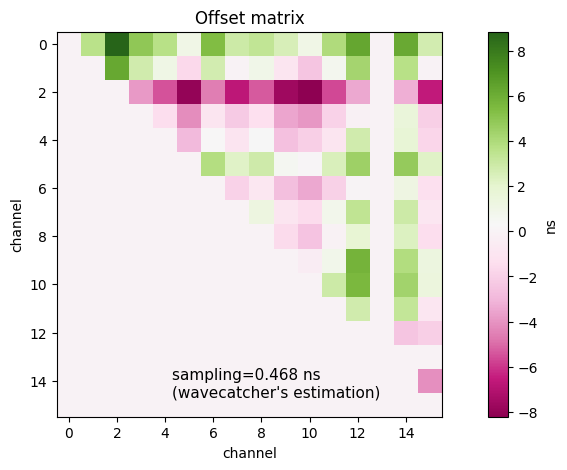

In [191]:
N_ch=16
a=offset_matrix_filling_cfd(N_ch, flag_cfd, lead_edge_cfd)
offset_matrix_cfd=a[0]
sigma_matrix_cfd=a[1]
time_res_cfd=a[2]
print(offset_matrix[0])



plt.figure(figsize=(12,5))
plt.imshow(offset_matrix_cfd, cmap='PiYG')
plt.title("Offset matrix")
plt.xlabel("channel")
plt.ylabel("channel")

def ns_format(x, pos):
    return f'{x:.1f} ns'
cbar = plt.colorbar()
cbar.set_label('ns')  # Set colorbar label if needed
cbar.update_ticks()
plt.figtext(0.52, 0.15, "sampling=0.468 ns\n(wavecatcher's estimation)",  fontsize=11)


time_res_cfd = np.array(flatten(time_res_cfd))
msk=np.where(time_res_cfd != 0)
#_, _, _=plt.hist(time_res[msk], bins=100, range=(-15,15))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(101,)
[240.53085675  -1.81861805   4.98700106]
[ 4.66255501e+02 -2.11295778e-01  2.48879629e+00]


/var/folders/f5/v4f5q2zj2c19xqbmyrk3xnq40000gn/T/ipykernel_80541/2243424516.py:21: RuntimeWarning: invalid value encountered in sqrt
  print(np.sqrt(edges).shape)


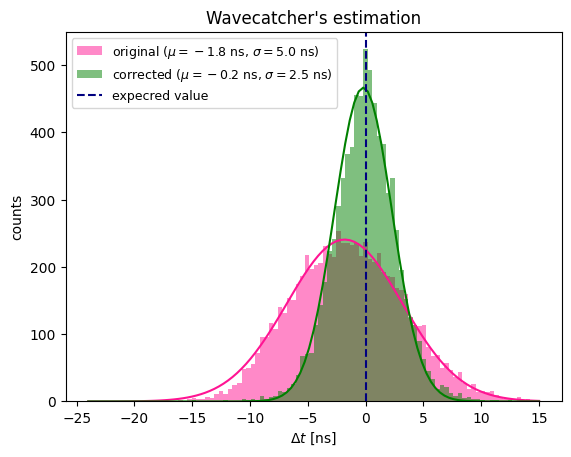

In [150]:
time_res_cfd_new=[]
N_ch=16
for i in range(N_ch):
    for j in range(N_ch):
        tmp=resolution_estimation_corrected_cfd([i,j], flag_cfd, lead_edge_cfd, offset_matrix_cfd)
        time_res_cfd_new.append(tmp[3])

time_res_cfd_new = np.array(flatten(time_res_cfd_new))
msk_new=np.where(time_res_cfd_new != 0)
std=np.std(time_res_cfd[ (time_res_cfd != 0) & (np.abs(time_res_cfd) < 30) ])
std_new=np.std(time_res_cfd_new[(time_res_cfd_new != 0) & (np.abs(time_res_cfd_new) < 30)])





plt.legend(fontsize=9)
plt.xlabel("$\Delta t$ [ns]")
plt.ylabel("counts")
plt.title("Wavecatcher's estimation")
print(np.sqrt(edges).shape)

def gaussian(x, A, mu, sigma):
    return(A*np.exp(-(x-mu)**2/(2*sigma**2)))


popt, popc =scipy.optimize.curve_fit(gaussian,  edges[:-1], bins, p0=[20000, -4, 4] )
bins, edges, _=plt.hist(time_res_cfd[msk], bins=100, range=(-24,15), alpha=0.5,  color='deeppink', label='original ($\mu={:.1f}$ ns, $\sigma={:.1f}$ ns)'.format(popt[1], popt[2]))
print(popt)
plt.plot(edges, gaussian(edges, *popt), color='deeppink')

popt, popc =scipy.optimize.curve_fit(gaussian,  edges_new[:-1], bins_new, p0=[40000, 0, 2])
bins_new, edges_new, _=plt.hist(time_res_cfd_new[msk_new], bins=100, range=(-24,15), color='green', alpha=0.5, label='corrected ($\mu={:.1f}$ ns, $\sigma={:.1f}$ ns)'.format(popt[1], popt[2]))
print(popt)
plt.plot(edges_new, gaussian(edges_new, *popt), color='green')

plt.axvline(x=0, ymin=0, ymax=400,color='navy', linestyle='--', label='expecred value')

plt.legend(fontsize=9, loc='upper left')




# sampling 468 ps

14112 16
[719, 2] [ 0.  0.  0.  0.  0. 15.  0.  0.  0.  0.] [ 80. 124.  93.  40.  59. 105.  54.  84.  53.  27.]


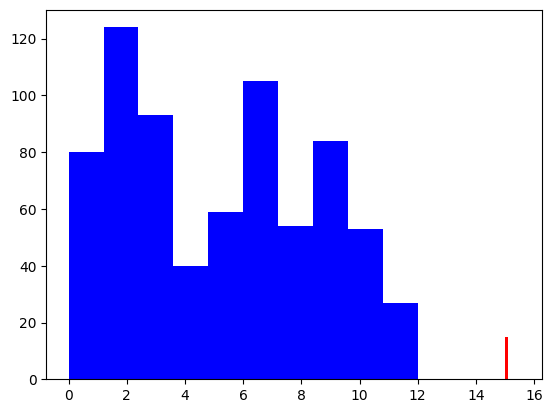

In [192]:
N_ch= len(charges[0])
N_ev=len(charges)
print(N_ev, N_ch)

ch=14
msk=np.where(flag[:,0]== ch)[0]
bin_1, _, _=plt.hist(flag[msk, 1],color = "red")
msk=np.where(flag[:,1]== ch)[0]
bin_2,_, _=plt.hist(flag[msk, 0],color="blue")

print(np.shape(flag[msk, :]), bin_1, bin_2)

ad ogni event è associata una flag, ora devo selezionare tutti gli event con una stessa flag

In [194]:
def timing_measurement(paired_wf_1, sampling, shiftR, shiftL, n_mean, thresh):
    wf_1_len = len(paired_wf_1)
    new_wf_1 = np.array(paired_wf_1).reshape([np.array(paired_wf_1).shape[0], 1, np.array(paired_wf_1).shape[1]])

    for evt in range(new_wf_1.shape[0]):
        for ch in range(new_wf_1.shape[1]):
            bsl_1 = new_wf_1[evt, ch, 0:32].mean()
            new_wf_1[evt, ch, :] = np.convolve(new_wf_1[evt, ch], [1/n_mean] * n_mean, mode = "same") - bsl_1

    new_wf_1 = -norm(-new_wf_1.reshape(-1, 1024), norm = "max", axis = 1, copy = True, return_norm = False)
    threshold = thresh

    ledges1 = np.zeros(new_wf_1.shape[0])

    for evt in range(new_wf_1.shape[0]):
        try:
            ledge= np.where(np.diff(np.sign(new_wf_1[evt] - threshold)))[0][0]
            coef = np.polyfit(new_wf_1[evt][ledge-shiftL:ledge+shiftR],np.arange(ledge-shiftL, ledge+shiftR),1)
            ledges1[evt] = np.poly1d(coef)(threshold) 
        except IndexError:
            continue

    return ledges1*sampling

In [195]:
#data una coppia e un dataset la funzione ritorna l'offset relativo alla misura di timing
def offset_and_resolution_estimation( couple, flag, waveform, sampling, shiftR, shiftL, n_mean, thresh):
    idx=np.where( (flag[:,0]==couple[0] ) & (flag[:,1]==couple[1]) )[0]
    if(len(idx)>0):
        paired_wf_1=waveform[idx][:,couple[0]]
        paired_wf_2=waveform[idx][:,couple[1]]
        timeres=timing_measurement(paired_wf_1, sampling, shiftR, shiftL, n_mean, thresh)-timing_measurement(paired_wf_2, sampling, shiftR, shiftL, n_mean, thresh)
        msk=np.where(np.abs(timeres) < 50)[0]
        return(np.mean(timeres[msk]), np.std(timeres[msk]), np.std(timeres[msk])/len(msk), timeres.tolist())
    else:
        return(0,0,0,0)


In [196]:
def offset_matrix_filling(N_ch, flag, waveform, sampling, shiftR, shiftL, n_mean, thresh):
    offset_matrix=np.zeros((N_ch, N_ch))
    sigma_offset=np.zeros((N_ch, N_ch))
    time_res=[]
    for i in range(N_ch):
        for j in range(N_ch):
            tmp=offset_and_resolution_estimation([i,j], flag, waveform, sampling, shiftR, shiftL, n_mean, thresh)
            offset_matrix[i][j]=tmp[0]
            sigma_offset[i][j]=tmp[2]
            time_res.append(tmp[3])
    return(offset_matrix, sigma_offset, time_res)

In [198]:
def resolution_estimation_corrected( couple, flag, waveform, sampling, shiftR, shiftL, n_mean, thresh, offset_matrix):
    idx=np.where( (flag[:,0]==couple[0] ) & (flag[:,1]==couple[1]) )[0]
    if(len(idx)>0):
        paired_wf_1=waveform[idx][:,couple[0]]
        paired_wf_2=waveform[idx][:,couple[1]]
        timeres=timing_measurement(paired_wf_1, sampling, shiftR, shiftL, n_mean, thresh)-timing_measurement(paired_wf_2, sampling, shiftR, shiftL, n_mean, thresh)-offset_matrix[couple[0], couple[1]]
        msk=np.where(np.abs(timeres) < 50)[0]
        return(np.mean(timeres[msk]), np.std(timeres[msk]), np.std(timeres[msk])/len(msk), timeres.tolist())
    else:
        return(0,0,0,0)

def flatten(nested_list):
    flattened = []
    for item in nested_list:
        if isinstance(item, list):
            flattened.extend(flatten(item))
        else:
            flattened.append(item)
    return flattened

In [199]:
sampling=0.468
shiftR=4
shiftL=1
n_mean=30
thresh=-0.1
a=offset_and_resolution_estimation([1,1], flag, waveform, sampling, shiftR, shiftL, n_mean, thresh)
print(a[3])


0


[0.         1.97790006 8.30515642 5.13880779 3.25188705 0.60127363
 4.63887604 2.23860842 2.96122492 1.7662929  0.08214686 2.61439973
 5.75674346 0.         2.66775925 2.25991482]


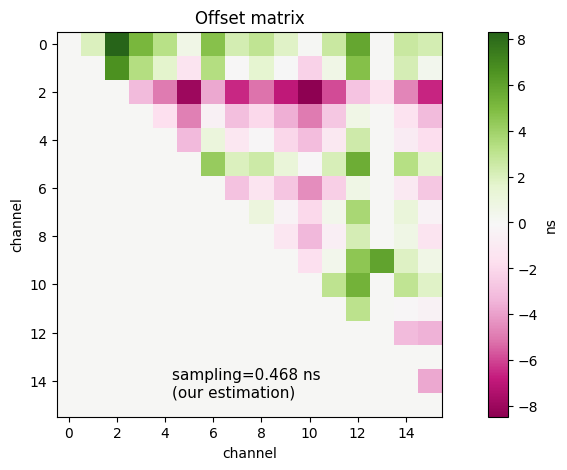

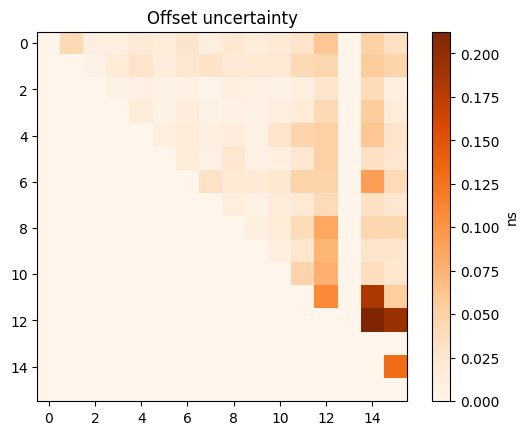

In [221]:
N_ch=16
a=offset_matrix_filling(N_ch, flag, waveform, sampling, shiftR, shiftL, n_mean, thresh)
offset_matrix=a[0]
sigma_matrix=a[1]
time_res=a[2]
print(offset_matrix[0])


time_res = np.array(flatten(time_res))
msk=np.where(time_res != 0)
#_, _, _=plt.hist(time_res[msk], bins=100, range=(-15,15))

plt.figure(figsize=(12,5))
plt.imshow(offset_matrix, cmap='PiYG')
plt.title("Offset matrix")
plt.xlabel("channel")
plt.ylabel("channel")

cbar = plt.colorbar()
cbar.set_label('ns')  # Set colorbar label if needed
cbar.update_ticks()
plt.figtext(0.52, 0.15, "sampling=0.468 ns\n(our estimation)",  fontsize=11)
plt.show()

plt.imshow(sigma_matrix,cmap='Oranges')
plt.title("Offset uncertainty")
cbar = plt.colorbar()
cbar.set_label('ns')  # Set colorbar label if needed


<class 'list'>


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


4.221700100803878 1.716986436933152
(101,)
[500.39279284  -2.03580871   4.38487184]
[ 1.29910410e+03 -2.03907822e-01  1.66343421e+00]


/var/folders/f5/v4f5q2zj2c19xqbmyrk3xnq40000gn/T/ipykernel_80541/3468546804.py:19: RuntimeWarning: invalid value encountered in sqrt
  print(np.sqrt(edges).shape)


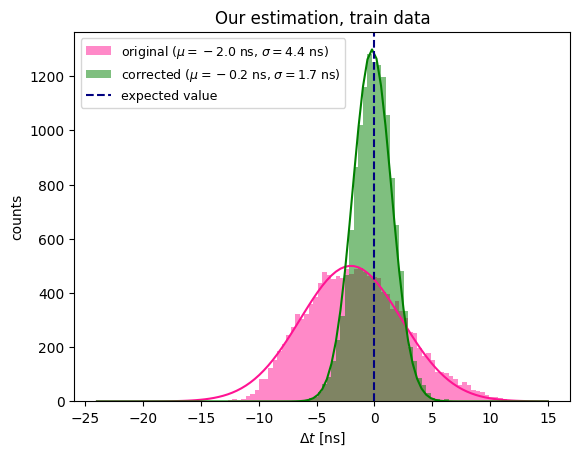

In [228]:
time_res_new=[]
print(type(time_res_new))
N_ch=16
for i in range(N_ch):
    for j in range(N_ch):
        tmp=resolution_estimation_corrected([i,j], flag, waveform, sampling, shiftR, shiftL, n_mean, thresh, offset_matrix)
        time_res_new.append(tmp[3])

time_res_new = np.array(flatten(time_res_new))
msk_new=np.where(time_res_new != 0)

print(np.std(time_res[ (time_res != 0) & (np.abs(time_res) < 15) ]), np.std(time_res_new[(time_res_new != 0) & (np.abs(time_res_new) < 15)]))


plt.legend(fontsize=9)
plt.xlabel("$\Delta t$ [ns]")
plt.ylabel("counts")
plt.title("Our estimation, train data")
print(np.sqrt(edges).shape)

def gaussian(x, A, mu, sigma):
    return(A*np.exp(-(x-mu)**2/(2*sigma**2)))



bins, edges, _=plt.hist(time_res[msk], bins=100, range=(-24,15), alpha=0)
popt, popc =scipy.optimize.curve_fit(gaussian,  edges[:-1], bins, p0=[20000, -4, 4] )
bins, edges, _=plt.hist(time_res[msk], bins=100, range=(-24,15), alpha=0.5,  color='deeppink', label='original ($\mu={:.1f}$ ns, $\sigma={:.1f}$ ns)'.format(popt[1], popt[2]))
print(popt)
plt.plot(edges, gaussian(edges, *popt), color='deeppink')


bins_new, edges_new, _=plt.hist(time_res_new[msk_new], bins=100, range=(-24,15), alpha=0)
popt, popc =scipy.optimize.curve_fit(gaussian,  edges_new[:-1], bins_new, p0=[80000, 0, 2])
bins_new, edges_new, _=plt.hist(time_res_new[msk_new], bins=100, range=(-24,15), color='green', alpha=0.5, label='corrected ($\mu={:.1f}$ ns, $\sigma={:.1f}$ ns)'.format(popt[1], popt[2]))
print(popt)
plt.plot(edges_new, gaussian(edges_new, *popt), color='green')

plt.axvline(x=0, ymin=0, ymax=400,color='navy', linestyle='--', label='expected value')

plt.legend(fontsize=9, loc='upper left')


# test su dati indipendenti

In [222]:
N_ch= len(charges_test[0])
N_ev=len(charges_test)
print(N_ev, N_ch)

print(waveform_test.shape)

659 16
(659, 16, 1024)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<class 'list'>
816
14244
[6.06344159e+01 1.70006309e-02 1.68022626e+00]
1.8007623168469111


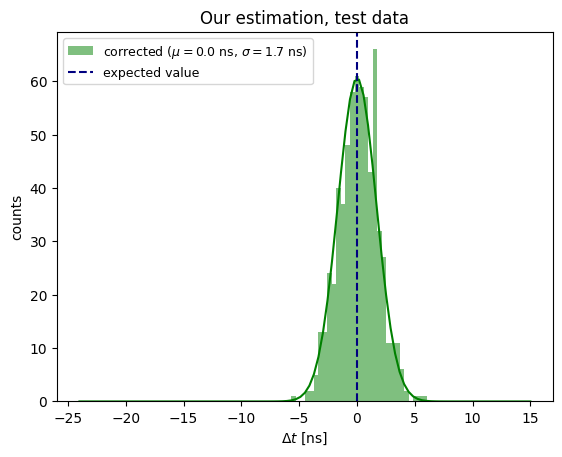

In [230]:
time_res_test=[]
print(type(time_res_test))
N_ch=16
for i in range(N_ch):
    for j in range(N_ch):
        tmp=resolution_estimation_corrected([i,j], flag_test, waveform_test, sampling, shiftR, shiftL, n_mean, thresh, offset_matrix)
        time_res_test.append(tmp[3])

time_res_test = np.array(flatten(time_res_test))
print(len(time_res_test))
msk_new=np.where(time_res_test != 0)
print(np.max(msk))

plt.legend(fontsize=9)
plt.xlabel("$\Delta t$ [ns]")
plt.ylabel("counts")
plt.title("Our estimation, test data")
bins_new, edges_new, _=plt.hist(time_res_test[msk_new], bins=100, range=(-24,15), alpha=0)
popt, popc =scipy.optimize.curve_fit(gaussian,  edges_new[:-1], bins_new, p0=[80000, 0, 2])
bins_new, edges_new, _=plt.hist(time_res_test[msk_new], bins=100, range=(-24,15), color='green', alpha=0.5, label='corrected ($\mu={:.1f}$ ns, $\sigma={:.1f}$ ns)'.format(popt[1], popt[2]))
print(popt)
plt.plot(edges_new, gaussian(edges_new, *popt), color='green')

plt.axvline(x=0, ymin=0, ymax=400,color='navy', linestyle='--', label='expected value')

plt.legend(fontsize=9, loc='upper left')


print(np.std(time_res_test[ (time_res_test != 0) & (np.abs(time_res_test) < 20) ]))

# Save offset matrix

['arr_0']
[[ 0.          1.97790006  8.30515642  5.13880779  3.25188705  0.60127363
   4.63887604  2.23860842  2.96122492  1.7662929   0.08214686  2.61439973
   5.75674346  0.          2.66775925  2.25991482]
 [-1.97790006  0.          6.65268982  3.35018406  1.62865816 -1.42310493
   3.35363686 -0.09357444  1.55745866 -0.03231273 -2.23996373  0.60939011
   4.72326522  0.          2.19416517  0.31886456]
 [-8.30515642 -6.65268982  0.         -3.16529453 -4.96229802 -7.97382458
  -3.7849691  -6.49220942 -5.17749042 -6.89120561 -8.45633986 -5.88758847
  -2.87454218 -1.5810066  -4.69470296 -6.61630156]
 [-5.13880779 -3.35018406  3.16529453  0.         -1.74554839 -4.80185979
  -0.55825317 -3.03106198 -1.99820973 -3.57586387 -4.96672159 -2.73908285
   0.62833715  0.         -1.49089966 -3.16862866]
 [-3.25188705 -1.62865816  4.96229802  1.74554839  0.         -3.28007198
   1.04874026 -1.23946888 -0.16332661 -2.06401735 -3.11165703 -1.13443192
   2.46599326  0.         -0.9021026  -1.78743

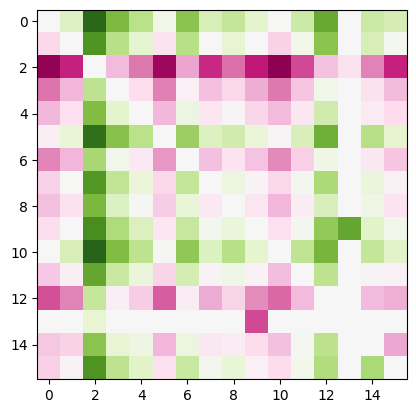

In [231]:
for i in range(N_ch):
    for j in range(i):
        offset_matrix[i][j]=-offset_matrix[j][i]

plt.imshow(offset_matrix, cmap='PiYG')

def save_matrix(filename, offset_matrix):
    np.savez(filename, offset_matrix)

def load_matrix(filename):
    return(np.load(filename))

save_matrix('offset_matrix.npz', offset_matrix)
loaded=load_matrix('offset_matrix.npz')
print(loaded.files)
matrix_loaded = loaded['arr_0']
print(matrix_loaded)

[ 0.00000000e+00 -3.33124039e+00  1.05223040e+00 -2.07374136e+00
 -1.64573129e+00  3.46512440e-02 -1.40353046e-01 -7.21857620e-01
  2.68886516e-01  1.22494899e+00  2.35320691e+00 -1.09864324e+00
 -2.61464357e-01  2.95907332e+00 -1.42024325e+00  4.73808545e-01
  1.06758526e+00 -1.73192213e+00 -2.10995365e+00 -9.19625697e-01
 -1.64723071e-01  1.70525391e+00  1.75845044e+00 -5.62887890e-01
 -3.03528361e+00  8.17307306e-01 -3.57271463e-01  8.05751994e-01
  9.32542727e-01 -5.33368973e-03 -2.59382234e+00  1.55924213e+00
 -2.00848779e+00  3.42284817e-01  6.17139376e-01 -6.75803839e-01
  1.62155835e+00 -1.70650293e+00 -1.22391826e+00 -1.01915897e-01
 -1.66398319e-01 -5.70954223e-01 -9.53221121e-01 -3.37293042e-01
  9.37190397e-01 -3.15006868e+00 -1.10263974e+00  9.82446253e-01
  3.30960401e+00 -1.27599574e+00  1.32777027e+00  3.82345327e+00
  2.64119387e+00  4.21087982e-01 -2.71720753e-01  3.50199447e-01
  2.22604847e+00  0.00000000e+00  3.80536534e+00 -3.63383412e-01
 -5.03503851e-01  0.00000

# sampling 2500 ps

In [ ]:
N_ch= len(charges_2500[0])
N_ev=len(charges_2500)
print(N_ev, N_ch)

7452 16


(936, 2) [ 0.  0.  0.  0.  0. 47.  0.  0.  0.  0.] [124. 102.  77.  60.  64. 130.  65.  92.  91. 131.]


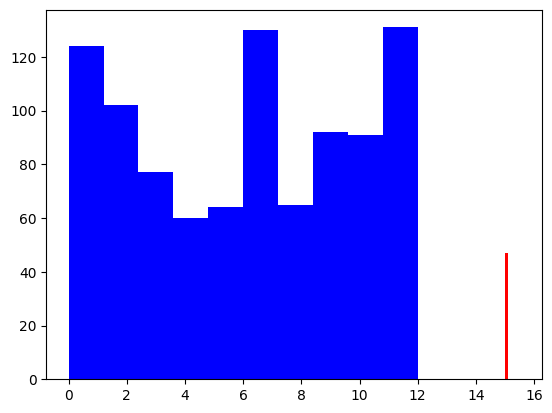

In [ ]:
ch=14
msk=np.where(flag_2500[:,0]== ch)[0]
bin_1, _, _=plt.hist(flag_2500[msk, 1],color = "red")
msk=np.where(flag_2500[:,1]== ch)[0]
bin_2,_, _=plt.hist(flag_2500[msk, 0],color="blue")

print(np.shape(flag_2500[msk, :]), bin_1, bin_2)

In [ ]:
print(offset_matrix[0])

[0.         1.38187253 8.31786349 5.17512394 3.35986042 0.74819754
 4.53816511 2.2289446  3.04694161 1.32099059 0.17669283 2.44340537
 6.05595569 0.         1.76219085 1.81066295]


[0.         1.38187253 8.31786349 5.17512394 3.35986042 0.74819754
 4.53816511 2.2289446  3.04694161 1.32099059 0.17669283 2.44340537
 6.05595569 0.         1.76219085 1.81066295]


Text(0, 0.5, 'channel')

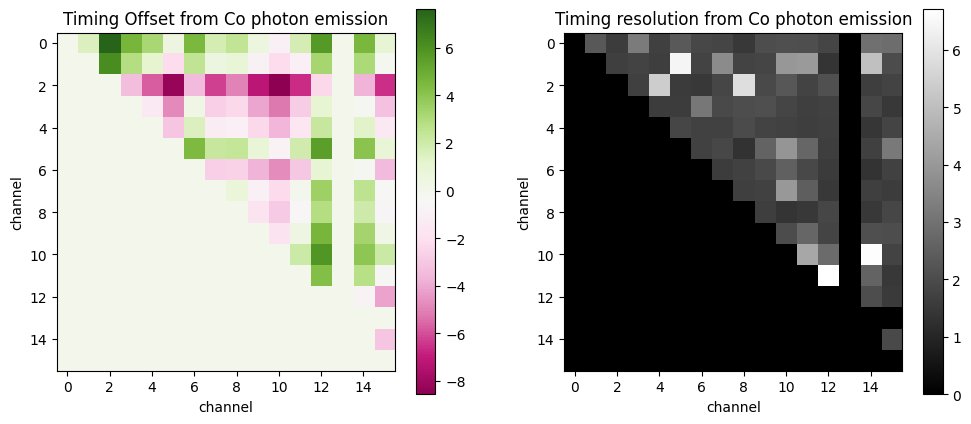

In [ ]:
sampling=2.5
shiftR=2
shiftL=0
n_mean=8
thresh=-0.1

N_ch=16
print(offset_matrix[0])
a=offset_matrix_filling(N_ch, flag_2500, waveform_2500, sampling, shiftR, shiftL, n_mean, thresh)
offset_matrix_2500=a[0]
sigma_matrix_2500=a[1]
time_res_2500=a[2]
time_res_2500 = np.array(flatten(time_res_2500))
msk=np.where(time_res_2500 != 0)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(offset_matrix_2500, cmap='PiYG')
plt.title("Timing Offset from Co photon emission")
plt.colorbar()
plt.xlabel("channel")
plt.ylabel("channel")

plt.subplot(1,2,2)
plt.imshow(sigma_matrix_2500, cmap='gray')
plt.title("Timing resolution from Co photon emission")
plt.colorbar()
plt.xlabel("channel")
plt.ylabel("channel")

<class 'list'>
4.040662535946477 1.6940829927787613


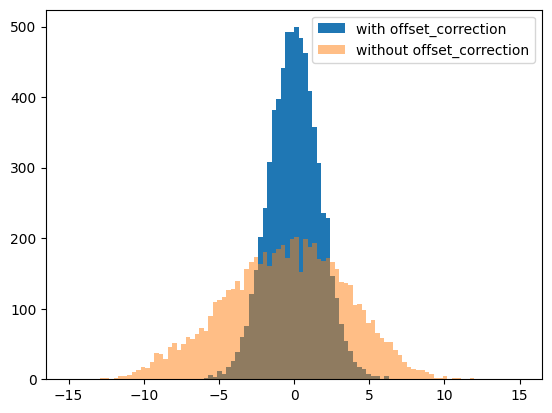

In [ ]:
time_res_2500_new=[]
print(type(time_res_2500_new))
N_ch=16
for i in range(N_ch):
    for j in range(N_ch):
        tmp=resolution_estimation_corrected([i,j], flag_2500, waveform_2500, sampling, shiftR, shiftL, n_mean, thresh, offset_matrix_2500)
        time_res_2500_new.append(tmp[3])

time_res_2500_new = np.array(flatten(time_res_new))
msk_new=np.where(time_res_2500_new != 0)
_, _, _=plt.hist(time_res_2500_new[msk_new], bins=100, range=(-15,15), label='with offset_correction')
_, _, _=plt.hist(time_res_2500[msk], bins=100, range=(-15,15), alpha=0.5, label='without offset_correction')
plt.legend()

print(np.std(time_res_2500[ (time_res_2500 != 0) & (np.abs(time_res_2500) < 15) ]), np.std(time_res_2500_new[(time_res_2500_new != 0) & (np.abs(time_res_2500_new) < 15)]))

[0.         1.38187253 8.31786349 5.17512394 3.35986042 0.74819754
 4.53816511 2.2289446  3.04694161 1.32099059 0.17669283 2.44340537
 6.05595569 0.         1.76219085 1.81066295]
[ 0.          1.50500943  7.62525845  4.61293362  3.15892701  0.42782056
  4.49672154  1.77843779  2.40697245  0.59281318 -0.90675317  1.68751028
  5.71198922  0.          4.56768762  0.97792598]


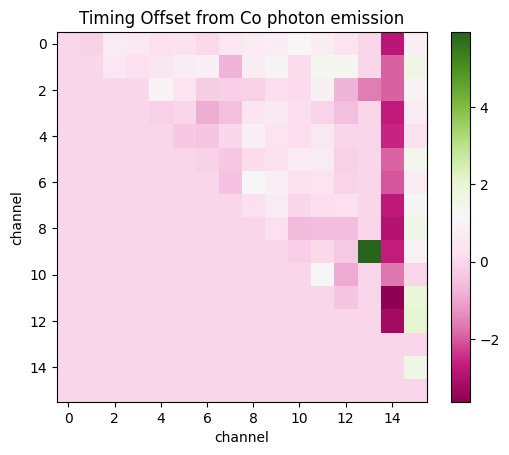

In [ ]:
#calcolo la differenza tra gli offset a 2500 e quelli a 468
plt.imshow(offset_matrix-offset_matrix_2500, cmap='PiYG')
plt.title("Timing Offset from Co photon emission")
plt.colorbar()
plt.xlabel("channel")
plt.ylabel("channel")

print(offset_matrix[0])
print(offset_matrix_2500[0])

In [ ]:
print(np.abs(sigma_matrix/offset_matrix))

/var/folders/f5/v4f5q2zj2c19xqbmyrk3xnq40000gn/T/ipykernel_77998/3486559899.py:1: RuntimeWarning: invalid value encountered in divide
  print(np.abs(sigma_matrix/offset_matrix))


[[        nan  1.40126483  0.51052536  0.3185908   0.49425989  2.36479201
   0.37849469  0.69728547  0.60969258  1.29248733 11.31478332  0.60313571
   0.2509946          nan  1.04585239  0.0442332 ]
 [        nan         nan  0.22257378  0.57290033  2.20527177  1.33919099
   0.48833584 19.53004043  0.94012719 17.39720492  0.74785082  4.62414156
   0.27277858         nan  1.47147391  1.16790034]
 [        nan         nan         nan  0.53396173  0.32556096  0.3343681
   0.42190456  0.23129351  0.8467876   0.47040808  0.18004249  0.20897637
   0.87756517  0.          1.05907926  0.2032672 ]
 [        nan         nan         nan         nan  1.10961815  0.33459323
   2.63481436  0.52515991  1.01599578  0.53298532  0.33146096  0.51893305
   4.04790365         nan  0.69891652  0.66304203]
 [        nan         nan         nan         nan         nan  0.85677088
   1.48185805  2.57055521  7.69434582  0.96976606  0.43643499  2.03801169
   0.78583079         nan  1.85721356  0.25410452]
 [    

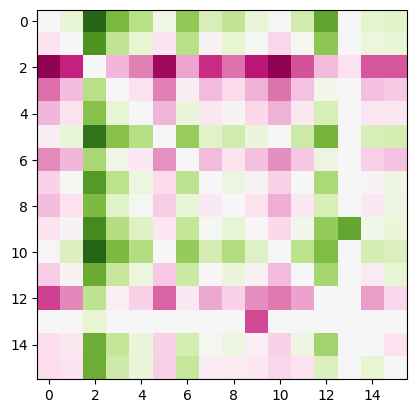

['arr_0']
[[ 0.          1.38187253  8.31786349  5.17512394  3.35986042  0.74819754
   4.53816511  2.2289446   3.04694161  1.32099059  0.17669283  2.44340537
   6.05595569  0.          1.76219085  1.81066295]
 [-1.38187253  0.          6.63130884  3.08321902  1.56085596 -1.42436184
   3.31263649 -0.27002431  1.5401779   0.20180509 -2.0706521   0.30490605
   4.57495114  0.          1.10332797  1.3971629 ]
 [-8.31786349 -6.63130884  0.         -3.34271168 -4.75683674 -7.88589878
  -3.76222109 -6.43956906 -5.10787089 -7.02622831 -8.44476913 -5.71107384
  -3.12476136 -1.57517162 -5.64903925 -5.62315052]
 [-5.17512394 -3.08321902  3.34271168  0.         -1.49626089 -4.8014284
  -0.68136343 -3.21157612 -1.89431539 -3.49485563 -5.08918001 -2.84121581
   0.50915704  0.         -2.93159673 -2.52846673]
 [-3.35986042 -1.56085596  4.75683674  1.49626089  0.         -3.38142368
   1.17680446 -1.10830173 -0.20296721 -1.91677204 -3.46563689 -1.07002225
   2.20121727  0.         -1.29611636 -1.176552